In [488]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [489]:
# Reding the .csv file(s)

shop = pd.read_csv('3.csv')

In [490]:
# Observing the df structure

shop.head()

,start_datetime,end_datetime,sales_total
0,2020-01-01 07:00:00,2020-01-01 07:59:59,10.44
1,2020-01-01 08:00:00,2020-01-01 08:59:59,454.55
2,2020-01-01 09:00:00,2020-01-01 09:59:59,602.84
3,2020-01-01 10:00:00,2020-01-01 10:59:59,1152.37
4,2020-01-01 11:00:00,2020-01-01 11:59:59,1361.62


In [491]:
# Checking for outliers and anomalies 

shop.describe()

,sales_total
count,13439.000000
mean,768.322801
std,474.528743
min,-12.960000
25%,372.220000
50%,707.010000
75%,1141.200000
max,2353.590000


In [492]:
# If there are outliers, how frequent are they. Negative values might mean returned merchendise so not removed from dataset

print(np.percentile(shop['sales_total'],95))

1580.0259999999998


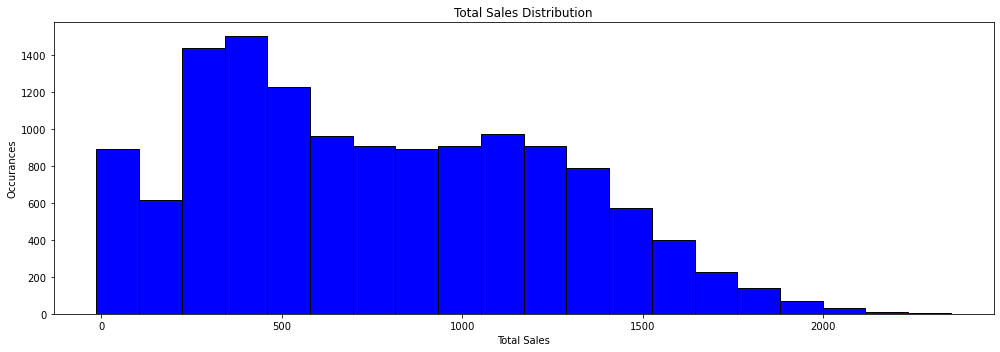

In [493]:
plt.figure(figsize=(14, 5))
plt.hist(shop['sales_total'], color = 'blue', edgecolor = 'black',
         bins = 20)

plt.title('Total Sales Distribution')
plt.xlabel('Total Sales')
plt.ylabel('Occurances')
plt.tight_layout()

In [494]:
shop[['start_datetime','end_datetime']] = shop[['start_datetime','end_datetime']].apply(pd.to_datetime)

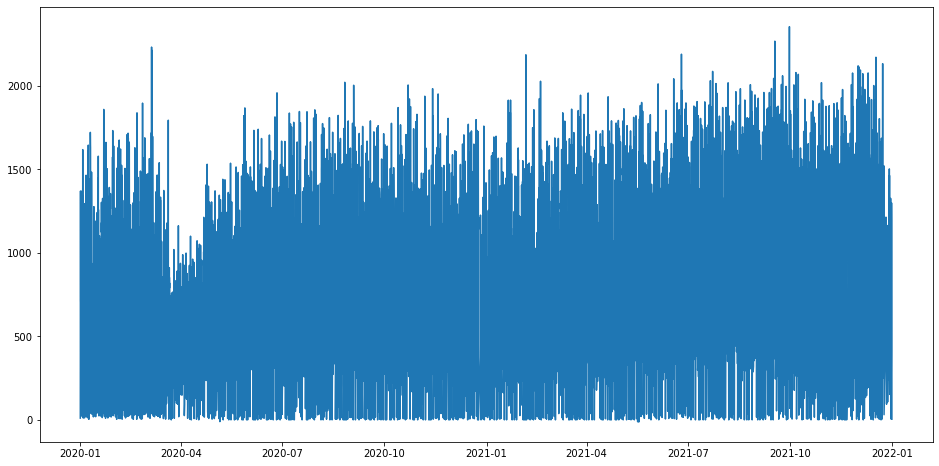

In [495]:
plt.figure(figsize=(16, 8))
plt.plot(shop['start_datetime'],shop['sales_total'])

In [496]:
# Checking for nul values


shop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13439 entries, 0 to 13438
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   start_datetime  13439 non-null  datetime64[ns]
 1   end_datetime    13439 non-null  datetime64[ns]
 2   sales_total     13439 non-null  float64       
dtypes: datetime64[ns](2), float64(1)
memory usage: 315.1 KB


In [497]:
# Checking for time delta and is it uniform

(shop['end_datetime']-shop['start_datetime']).value_counts()

0 days 00:59:59    13439
dtype: int64

In [498]:
# Checking for duplicate values

shop.duplicated().value_counts()

False    13439
dtype: int64

In [499]:
# Adding missing hours in our dataset

mdl = shop.set_index(pd.DatetimeIndex(shop['start_datetime']))

complete_index = pd.date_range(start=mdl.index.min(), end=mdl.index.max(), freq='H')

mdl = mdl.reindex(complete_index)

mdl.notna().value_counts()

start_datetime  end_datetime  sales_total
True            True          True           13439
False           False         False           4093
dtype: int64

In [500]:
# Putting total sales as 0 instead of NaN in hours where there was no transation

mdl.fillna(0,inplace=True)

In [501]:
# Spliting time series data into training and testing. Last x days of the dataset is used for testing data set

x = 20

split_perc = int(len(mdl) * ((len(mdl)-24*x)/len(mdl)))

train = mdl[:split_perc]
test = mdl[split_perc:]

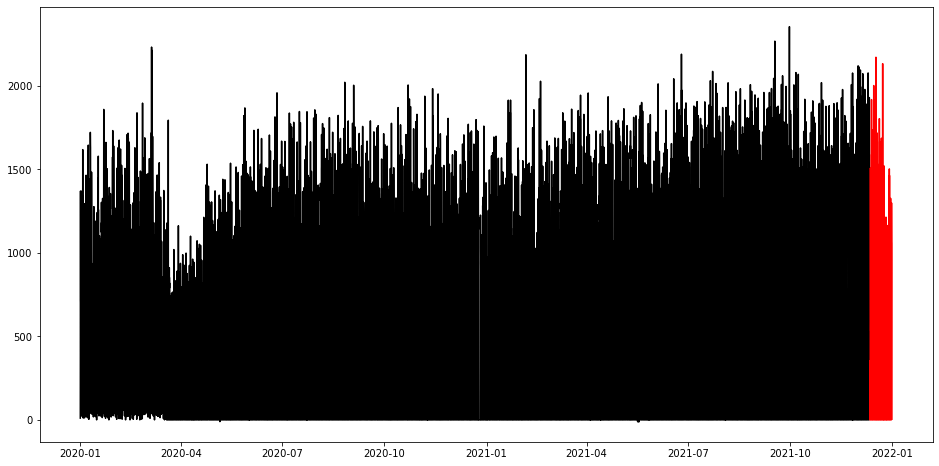

In [502]:
plt.figure(figsize=(16, 8))
plt.plot(train.index,train['sales_total'], color = "black")
plt.plot(test.index, test['sales_total'], color = "red")


In [503]:
# Defining and fitting the model
 
arm = SARIMAX(train['sales_total'], order=(5,0,1), seasonal_order=(1,0,1,24), enforce_stationarity=False)

arm = arm.fit()

pred = arm.get_forecast(len(test.index))

c:\Users\fkoze\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [504]:
# Making predictions

pred_df = arm.predict(start = len(train), end = len(train)+len(test)-1)

pred_df.index = test.index

pred_out = pred_df

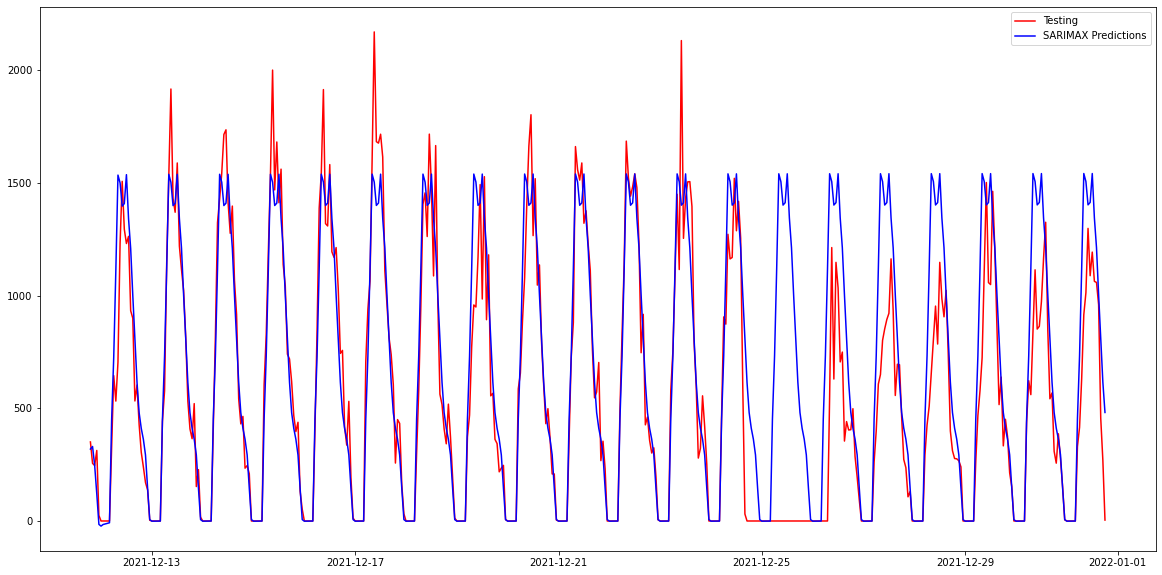

In [505]:
# Comparing testing and predicted data

plt.figure(figsize=(20, 10))
plt.plot(test.index, test['sales_total'], color = "red", label = 'Testing')
plt.plot(pred_out.index,pred_out, color='blue', label = 'SARIMAX Predictions')

plt.legend()

In [506]:
# Model statistics. Easist to read would be a std err 

arm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        sales_total   No. Observations:                17052
Model:             SARIMAX(5, 0, 1)x(1, 0, 1, 24)   Log Likelihood             -112297.198
Date:                            Mon, 13 May 2024   AIC                         224612.396
Time:                                    12:57:39   BIC                         224682.077
Sample:                                01-01-2020   HQIC                        224635.373
                                     - 12-11-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7405      0.208      3.568      0.000       0.334       1.147
ar.L2         -0.0473      0.087     -0.545      0.586      -0.217       0.123
ar.L3          0.0701      0.024      2.866      0.004       0.022       0.118
ar.L4         -0.0954      0.027     -3.580      0.000      -0.148      -0.043
ar.L5          0.0779      0.015      5.220      0.000       0.049       0.107
ma.L1         -0.3272      0.208     -1.574      0.115      -0.735       0.080
ar.S.L24       1.0001      0.000   5719.600      0.000       1.000       1.000
ma.S.L24      -0.9667      0.003   -346.481      0.000      -0.972      -0.961
sigma2      5.342e+04    665.350     80.289      0.000    5.21e+04    5.47e+04
===================================================================================
Ljung-Box (L1) (Q):                  60.21   Jarque-Bera (JB):             10414.82
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.28   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [507]:
# Creating dataframe for future predictions

shop_prediction = pd.DataFrame({'start_datetime' : pd.date_range('2023-01-01 00:00:00','2023-01-08 00:00:00', freq='1H'),
                                'end_datetime' : pd.date_range('2023-01-01 00:59:59','2023-01-08 00:59:59', freq='1H'),
                                'sales_total' : float()
                                })

In [508]:
shop_prediction = shop_prediction.set_index(pd.DatetimeIndex(shop_prediction['start_datetime']))

In [509]:
shop_prediction['sales_total'] = arm.predict(start=shop_prediction.index[0], end=shop_prediction.index[-1])

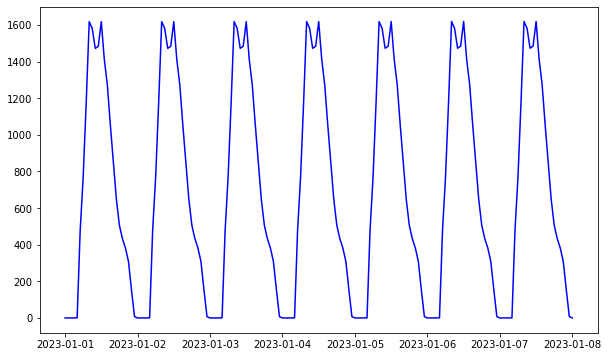

In [510]:
plt.figure(figsize=(10, 6))
plt.plot(shop_prediction.index,shop_prediction['sales_total'], color='blue', label = 'SARIMAX Predictions')

In [511]:
shop_prediction.to_csv("submission_3.csv",index=False, index_label=False,header='values')